In [101]:
import os
import glob
from Bio import SeqIO
from tqdm.auto import tqdm
import pylev
import matplotlib.pyplot as plt
import numpy as np

## Load all the unique sequences
These are the results for searching a database for homologues of:
- thioamide
- macroamidine
- azoline

In [158]:
seqdump_dirs = glob.glob("../**/**seqdump.fa",recursive = True)

unique_sequence_ids = []
unique_sequences = []
num_sequences = 0
seqrecs_list = []
selected_seqdump_dirs = []
for seqdump_dir in seqdump_dirs:
    seqrecs = [seqrec for seqrec in SeqIO.parse(seqdump_dir,"fasta")]
    print(f"{seqdump_dir} has {len(seqrecs)} sequences")
    seqrecs_list.append(seqrecs)
    #Me removing certain files
    if ("Lasso" in seqdump_dir):
        selected_seqdump_dirs.append(seqdump_dir)

seqdump_dirs = selected_seqdump_dirs
#End of me removing certain files

for i in tqdm(range(len(seqdump_dirs)), desc='Loading all sequences'):
    seqrecs = seqrecs_list[i]
    seqdump_dir = seqdump_dirs[i]
    YcaO_type = seqdump_dir.split("/")[-3]
    YcaO_subclass = seqdump_dir.split("/")[-2]
    #print(YcaO_type,YcaO_subclass)
    for seqrec in seqrecs[:]:
        num_sequences += 1
        if seqrec.id not in unique_sequence_ids and num_sequences % 5 == 0:
            unique_sequence_ids.append(seqrec.id)
            #seqrec.id = f"{YcaO_type}_{YcaO_subclass}_{seqrec.id}"
            unique_sequences.append(seqrec)
            

# '''OVERWRITING UNIQUE SEQUENCES FOR SPEED OF PROCESSING'''
# unique_sequences = [seqrec for seqrec in SeqIO.parse("../raw_sequences/Azoline/Mccb17/HMMER_seqdump.fa","fasta")]     
print(f'From {num_sequences} searched sequences {len(unique_sequences)} are unique. Loaded in unique_sequences variable.')

../raw_sequences/Amidine/Lasso_peptides/HMMER_seqdump.fa has 1665 sequences
../raw_sequences/Amidine/Jesko_but_unknown/HMMER_seqdump.fa has 14 sequences
../raw_sequences/Amidine/Bottromycin/HMMER_seqdump.fa has 273 sequences
../raw_sequences/Amidine/Jesko_but_unknown_outgroup/outgroup_sequence_HMMER_seqdump.fa has 1779 sequences
../raw_sequences/Azoline/Goadsporin/HMMER_seqdump.fa has 1750 sequences
../raw_sequences/Azoline/Thiopeptide_Lactazole/HMMER_seqdump.fa has 1595 sequences
../raw_sequences/Azoline/Thiostrepton/HMMER_seqdump.fa has 1205 sequences
../raw_sequences/Azoline/Sag/HMMER_seqdump.fa has 576 sequences
../raw_sequences/Azoline/Mccb17/HMMER_seqdump.fa has 13 sequences
../raw_sequences/Azoline/PZN/HMMER_seqdump.fa has 211 sequences
../raw_sequences/Azoline/Cyanobactins/PatD_HMMER_seqdump.fa has 1854 sequences
../raw_sequences/Azoline/Cyanobactins/TruD_HMMER_seqdump.fa has 1858 sequences
../raw_sequences/Azoline/Bottromycin/HMMER_seqdump.fa has 5 sequences
../raw_sequences/A

Loading all sequences: 100%|██████████| 1/1 [00:00<00:00, 231.79it/s]

From 1665 searched sequences 333 are unique. Loaded in unique_sequences variable.


## Remove sequences that are too short to be considered YcaO or too long to be useful
# <center> A.K.A len > 700 or len < 300 </center>

In [166]:
filtered_sequences = []

for seq_rec in unique_sequences:
    if(len(seq_rec.seq)<700 and len(seq_rec.seq)>300):
        filtered_sequences.append(seq_rec)

print(f'From {len(unique_sequences)} unique sequences. {len(filtered_sequences)} remain after processing')

From 333 unique sequences. 326 remain after processing


## Save unique sequences to file for intermediate bash processing

In [160]:
file_dir = './../processed_sequences/'
unique_seq_fp = os.path.join(file_dir, "unique_unaligned_sequences.txt")
SeqIO.write(filtered_sequences, unique_seq_fp, "fasta")

326

## Remove Sequences with High Similarity using CD-HIT eg. 90% or 70% identity etc

In [161]:
identity_percentage = 0.95
filtered_by_identity_unique_seq_fp = os.path.join(file_dir, f"unique_filtered_{identity_percentage}_sequences.txt")

!./../external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit -i $unique_seq_fp -o $filtered_by_identity_unique_seq_fp -c $identity_percentage -n 5 -d 0 -T 8 -M 16000

num_sequences = len([seq.id for seq in SeqIO.parse(filtered_by_identity_unique_seq_fp,"fasta")])
print(f"Started with {len(filtered_sequences)} sequences, after removing those with >{identity_percentage*100}% identity, we have {num_sequences} sequences!")
print(f"Saved as {filtered_by_identity_unique_seq_fp}")

Program: CD-HIT, V4.8.1 (+OpenMP), Dec 13 2022, 11:04:39
Command: ./../external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit
         -i
         ./../processed_sequences/unique_unaligned_sequences.txt
         -o
         ./../processed_sequences/unique_filtered_0.95_sequences.txt
         -c 0.95 -n 5 -d 0 -T 8 -M 16000

Started: Sun Dec 18 15:29:11 2022
                            Output                              
----------------------------------------------------------------
total seq: 326
longest and shortest : 697 and 352
Total letters: 199244
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 8 X 10M = 85M
Table           : 2 X 65M = 130M
Miscellaneous   : 0M
Total           : 216M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 1972989856

# comparing sequences from          0  to        326
---------- new table with      324 representatives

      326  

## Compute aligned sequences using mafft

In [162]:
aligned_unique_seq_fp = os.path.join(file_dir, f"aligned_{identity_percentage}_identity_sequences.txt")

!mafft --auto --distout $filtered_by_identity_unique_seq_fp > $aligned_unique_seq_fp 

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  301 / 324
done.

Constructing a UPGMA tree (efffree=0) ... 
  320 / 324
done.

Progressive alignment 1/2... 
STEP   185 / 323 
Reallocating..done. *alloclen = 2408
STEP   304 / 323 
Reallocating..done. *alloclen = 3431
STEP   323 / 323 
done.

Making a distance matrix from msa.. 
  300 / 324
done.

Constructing a UPGMA tree (efffree=1) ... 
  320 / 324
done.

Progressive alignment 2/2... 
STEP   189 / 323 
Reallocating..done. *alloclen = 2397
STEP   318 / 323 
Reallocating..done. *alloclen = 3623
STEP   323 / 323 
done.

disttbfast (aa) Version 7.475
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)

rescale = 1
dndpre (aa) Version 7.475
alg=X, model=BLOSUM62, 1.53, +0.12, -0.00, noshift, amax=0.0
0 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 20

STEP 002-012-0  rejected..   ected. identical.    rejected. rejected. rejected. rejected. rejected. rejected. rejected. identical.    rejected. identical.    rejected. accepted. identical.    rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. identical.    rejected. rejected. rejected. identical.    identical.    rejected. rejected. accepted. rejected. rejected. rejected. identical.    identical.    rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. identical.    identical.    rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. identical.    rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. rejected. reject

done 002-001-1  rejected..    rejected. rejected. rejected. identical.    rejected. rejected. rejected. identical.   
dvtditr (aa) Version 7.475
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-i (Standard)
 Iterative refinement method (max. 2 iterations)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.



In [164]:
aligned_sequences = [seqrec for seqrec in SeqIO.parse(aligned_unique_seq_fp,"fasta")]
print(f"Aligned sequences have a length of {len(aligned_sequences[0].seq)} AAs")

Aligned sequences have a length of 1856 AAs


## Run Iq-Tree!

Best Model for 5sequences from each HMMER file was WAG+F+R5, (after filtering for long & short sequences it was Q.pfam+F+R4)

In [165]:
!iqtree2 -s $aligned_unique_seq_fp -T 47 -m Q.pfam+F+R4 -B 1000 -asr

IQ-TREE multicore version 2.2.0 COVID-edition for Linux 64-bit built Jun  1 2022
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    dc4b1604e884 (AVX2, FMA3, 251 GB RAM)
Command: iqtree2 -s ./../processed_sequences/aligned_0.95_identity_sequences.txt -T 47 -m Q.pfam+F+R4 -B 1000 -asr
Seed:    276675 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Sun Dec 18 15:32:28 2022
Kernel:  AVX+FMA - 47 threads (48 CPU cores detected)

Reading alignment file ./../processed_sequences/aligned_0.95_identity_sequences.txt ... Fasta format detected
Reading fasta file: done in 0.0158291 secs using 99.82% CPU
Alignment most likely contains protein sequences
Constructing alignment: done in 0.022012 secs using 1913% CPU
Alignment has 324 sequences with 1856 columns, 1783 distinct patterns
1077 parsimony-informative, 475 singleton sites, 304 constant sites
                  Gap/Ambiguit


Create initial parsimony tree by phylogenetic likelihood library (PLL)... 0.558 seconds
Generating 1000 samples for ultrafast bootstrap (seed: 276675)...

NOTE: 368 MB RAM (0 GB) is required!
Estimate model parameters (epsilon = 0.100)
1. Initial log-likelihood: -334199.300
2. Current log-likelihood: -312851.221
3. Current log-likelihood: -312574.034
4. Current log-likelihood: -312550.010
5. Current log-likelihood: -312537.983
6. Current log-likelihood: -312534.216
7. Current log-likelihood: -312534.010
Optimal log-likelihood: -312533.984
Site proportion and rates:  (0.072,0.142) (0.205,0.429) (0.307,0.861) (0.416,1.531)
Parameters optimization took 7 rounds (7.582 sec)
Wrote distance file to... 
Computing ML distances based on estimated model parameters...
Calculating distance matrix: done in 0.478116 secs using 4691% CPU
Computing ML distances took 0.478812 sec (of wall-clock time) 22.455896 sec (of CPU time)
Setting up auxiliary I and S matrices: done in 0.0186824 secs using 2253% 

Optimizing NNI: done in 5.04709 secs using 4686% CPU
Optimizing NNI: done in 4.69611 secs using 4685% CPU
Optimizing NNI: done in 5.36838 secs using 4686% CPU
Optimizing NNI: done in 5.09834 secs using 4686% CPU
Optimizing NNI: done in 6.34132 secs using 4686% CPU
Optimizing NNI: done in 4.81906 secs using 4687% CPU
Optimizing NNI: done in 4.28322 secs using 4686% CPU
Optimizing NNI: done in 5.09441 secs using 4687% CPU
Optimizing NNI: done in 4.40013 secs using 4685% CPU
Optimizing NNI: done in 4.97945 secs using 4686% CPU
Iteration 100 / LogL: -311615.765 / Time: 0h:10m:30s (0h:9m:13s left)
Log-likelihood cutoff on original alignment: -311801.701
NOTE: Bootstrap correlation coefficient of split occurrence frequencies: 0.975
NOTE: UFBoot does not converge, continue at least 100 more iterations
Optimizing NNI: done in 4.57759 secs using 4686% CPU
Optimizing NNI: done in 5.64744 secs using 4687% CPU
Optimizing NNI: done in 4.71459 secs using 4685% CPU
Optimizing NNI: done in 4.14031 sec

Optimizing NNI: done in 4.43085 secs using 4685% CPU
Optimizing NNI: done in 5.14278 secs using 4685% CPU
Optimizing NNI: done in 4.77145 secs using 4686% CPU
Optimizing NNI: done in 4.18776 secs using 4685% CPU
Optimizing NNI: done in 4.5321 secs using 4686% CPU
Optimizing NNI: done in 3.91693 secs using 4686% CPU
Iteration 220 / LogL: -311655.111 / Time: 0h:20m:17s (0h:7m:24s left)
Optimizing NNI: done in 4.89117 secs using 4685% CPU
Optimizing NNI: done in 4.71235 secs using 4686% CPU
Optimizing NNI: done in 4.76469 secs using 4686% CPU
Optimizing NNI: done in 4.30093 secs using 4686% CPU
Optimizing NNI: done in 4.93292 secs using 4686% CPU
Optimizing NNI: done in 5.58112 secs using 4686% CPU
Optimizing NNI: done in 5.29 secs using 4686% CPU
Optimizing NNI: done in 4.98222 secs using 4686% CPU
Optimizing NNI: done in 5.07109 secs using 4686% CPU
Optimizing NNI: done in 4.65936 secs using 4686% CPU
Iteration 230 / LogL: -311588.546 / Time: 0h:21m:6s (0h:6m:27s left)
Optimizing NNI: d

Optimizing NNI: done in 4.37035 secs using 4686% CPU
Optimizing NNI: done in 4.55593 secs using 4685% CPU
Optimizing NNI: done in 4.73759 secs using 4688% CPU
Optimizing NNI: done in 4.73324 secs using 4686% CPU
Optimizing NNI: done in 4.60623 secs using 4686% CPU
Optimizing NNI: done in 4.78803 secs using 4686% CPU
Optimizing NNI: done in 4.26703 secs using 4685% CPU
Optimizing NNI: done in 4.91068 secs using 4686% CPU
Optimizing NNI: done in 4.25988 secs using 4684% CPU
Optimizing NNI: done in 4.62811 secs using 4687% CPU
Iteration 350 / LogL: -311602.981 / Time: 0h:30m:38s (0h:4m:23s left)
Log-likelihood cutoff on original alignment: -311695.762
Optimizing NNI: done in 4.65738 secs using 4685% CPU
Optimizing NNI: done in 4.83131 secs using 4686% CPU
Optimizing NNI: done in 4.45555 secs using 4686% CPU
Optimizing NNI: done in 3.95902 secs using 4686% CPU
Optimizing NNI: done in 4.72024 secs using 4687% CPU
Optimizing NNI: done in 4.495 secs using 4687% CPU
Optimizing NNI: done in 4.4

Optimizing NNI: done in 5.12098 secs using 4686% CPU
Optimizing NNI: done in 5.1367 secs using 4685% CPU
Iteration 470 / LogL: -311611.832 / Time: 0h:40m:20s (0h:8m:15s left)
Optimizing NNI: done in 4.577 secs using 4686% CPU
Optimizing NNI: done in 4.37611 secs using 4686% CPU
Optimizing NNI: done in 4.50917 secs using 4684% CPU
Optimizing NNI: done in 4.88983 secs using 4686% CPU
Optimizing NNI: done in 4.78025 secs using 4686% CPU
Optimizing NNI: done in 5.07455 secs using 4686% CPU
Optimizing NNI: done in 5.04025 secs using 4686% CPU
Optimizing NNI: done in 4.71095 secs using 4685% CPU
Optimizing NNI: done in 4.24639 secs using 4686% CPU
Optimizing NNI: done in 4.62657 secs using 4686% CPU
Iteration 480 / LogL: -311594.804 / Time: 0h:41m:7s (0h:7m:22s left)
Optimizing NNI: done in 4.73766 secs using 4687% CPU
Optimizing NNI: done in 4.63947 secs using 4685% CPU
Optimizing NNI: done in 4.44524 secs using 4686% CPU
Estimate model parameters (epsilon = 0.100)
BETTER TREE FOUND at iter

Log-likelihood cutoff on original alignment: -311695.762
NOTE: Bootstrap correlation coefficient of split occurrence frequencies: 0.990
NOTE: UFBoot does not converge, continue at least 100 more iterations
Optimizing NNI: done in 4.16739 secs using 4686% CPU
Optimizing NNI: done in 4.53593 secs using 4686% CPU
Optimizing NNI: done in 4.67189 secs using 4686% CPU
Optimizing NNI: done in 4.05115 secs using 4686% CPU
Optimizing NNI: done in 4.55036 secs using 4686% CPU
Optimizing NNI: done in 4.58139 secs using 4686% CPU
Optimizing NNI: done in 4.25512 secs using 4686% CPU
Optimizing NNI: done in 4.96852 secs using 4687% CPU
Optimizing NNI: done in 4.99399 secs using 4685% CPU
Optimizing NNI: done in 5.0268 secs using 4686% CPU
Iteration 610 / LogL: -311576.683 / Time: 0h:51m:26s (0h:7m:36s left)
Optimizing NNI: done in 4.79061 secs using 4686% CPU
Optimizing NNI: done in 4.90605 secs using 4684% CPU
Optimizing NNI: done in 4.94216 secs using 4685% CPU
Optimizing NNI: done in 4.68633 secs

Optimizing NNI: done in 4.90315 secs using 4686% CPU
Optimizing NNI: done in 4.78394 secs using 4686% CPU
Optimizing NNI: done in 4.88788 secs using 4686% CPU
Optimizing NNI: done in 4.4713 secs using 4686% CPU
Optimizing NNI: done in 4.61166 secs using 4686% CPU
Optimizing NNI: done in 4.24348 secs using 4686% CPU
Optimizing NNI: done in 4.14683 secs using 4686% CPU
Optimizing NNI: done in 4.8474 secs using 4685% CPU
Optimizing NNI: done in 4.94943 secs using 4686% CPU
Optimizing NNI: done in 4.92078 secs using 4686% CPU
Iteration 740 / LogL: -311609.046 / Time: 1h:1m:45s (0h:5m:0s left)
Optimizing NNI: done in 4.4278 secs using 4643% CPU
Optimizing NNI: done in 4.6009 secs using 4687% CPU
Optimizing NNI: done in 4.92123 secs using 4686% CPU
Optimizing NNI: done in 4.43174 secs using 4686% CPU
Optimizing NNI: done in 4.58024 secs using 4686% CPU
Optimizing NNI: done in 4.46519 secs using 4686% CPU
Optimizing NNI: done in 4.64851 secs using 4686% CPU
Optimizing NNI: done in 4.76469 sec

## Find redundant sequences to save compute

In [68]:
def pairwise_sequence_identity(seq_rec_1, seq_rec_2):
    seq_1 = str(seq_rec_1.seq)
    seq_2 = str(seq_rec_2.seq)
    
    num_matching = 0
    length = 0
    for i in range(len(seq_1)):
        if seq_1[i] == '-' and seq_2[i] == '-':
            continue
        if seq_1[i] == seq_2[i]:
            num_matching += 1
        length += 1
    return num_matching/length
seq_1, seq_2 = aligned_sequences[:2]
print(f'Sequence identity test between\nseq 1: {str(seq_1.seq)[:200]}...\nand\nseq 2: {str(seq_2.seq)[:200]}...')
identity_similarity = pairwise_sequence_identity(seq_1, seq_2)
print(f'Identity similarity = {identity_similarity}')

Sequence identity test between
seq 1: --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------...
and
seq 2: --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------...
Identity similarity = 0.9601769911504425


In [ ]:
redundant_sequences = set()
threshold = 0.7 # anything above 70% identity to the current seq will be filtered out

print(type(enumerate(aligned_sequences)))
# pbar = tqdm(enumerate(aligned_sequences), desc='Filtering sequences', total=len(aligned_sequences))
# for i, sequence in pbar:
#     if i in redundant_sequences:
#         continue
#     comparison_sequences = [(seq, j) for j, seq in enumerate(aligned_sequences) if j != i and j not in redundant_sequences]
#     for comp_seq, comp_seq_idx in comparison_sequences:
#         identity_similarity = pairwise_sequence_identity(sequence, comp_seq)
#         if identity_similarity > threshold: # if above threshold, then flag as redundant
#             redundant_sequences.add(comp_seq_idx)
#             pbar.set_description(f'Filtering sequences, found {len(redundant_sequences)} redundant')
# #             print(f'Found {i} has redundant sequence with {identity_similarity*100:.2f}% similarity.')
# #             print(f'We have {len(redundant_sequences)} redundant sequences.')

In [57]:
filtered_sequences = [seq for i, seq in enumerate(aligned_sequences) if i not in redundant_sequences]

100%|██████████| 45/45 [00:00<00:00, 132.32it/s]


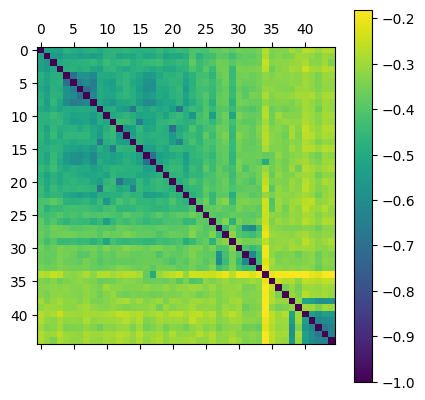

In [62]:
similarity_matrix = []

for i in tqdm(range(len(filtered_sequences))):
    row = []
    for j in range(len(filtered_sequences)):
        similarity = pairwise_sequence_identity(filtered_sequences[i], filtered_sequences[j])
        row.append(similarity)
    similarity_matrix.append(row)

m = np.array(similarity_matrix)
plt.matshow(-m)
plt.colorbar()

In [54]:
redundant_sequences

{1,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 17,
 18,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 39,
 41,
 42,
 44,
 48,
 49,
 50,
 51,
 52,
 55,
 56,
 57,
 58,
 62,
 63,
 64,
 65,
 67,
 70,
 72,
 81,
 85,
 91,
 92,
 96,
 97,
 98}

In [30]:
len(aligned_sequences)

999